In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,GlobalMaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,NASNetMobile,DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob

2024-04-01 08:49:59.821678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 08:49:59.821782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 08:49:59.943293: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [4]:
train_path="/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train"
test_path="/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test"
val_path="/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/val"

In [5]:
train_datagen = ImageDataGenerator( 
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #brightness_range=[0.5, 1.5],
                                  ) 
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(  rescale=1./255.0)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'binary',
                                            shuffle=False)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'binary')


Found 1887 images belonging to 2 classes.
Found 410 images belonging to 2 classes.
Found 402 images belonging to 2 classes.


In [6]:
base_model = MobileNet(input_shape=(224,224,3),weights='imagenet', include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
for layer in base_model.layers:
  layer.trainable=False

In [8]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
from keras.losses import SparseCategoricalCrossentropy

# Instantiate the loss function
loss_fn = SparseCategoricalCrossentropy()

In [10]:
model.compile(optimizer='adam', loss=loss_fn,
              metrics=['accuracy'])

In [11]:
history = model.fit(
    training_set,
    epochs=50,
    validation_data=val_set,
    #callbacks=[callbacks]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/30 ━━━━━━━━━━━━━━━━━━━━ 1:11:54 149s/step - accuracy: 0.5938 - loss: 0.9417

I0000 00:00:1711961584.687597      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711961584.716818      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/30 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - accuracy: 0.5898 - loss: 0.9822     

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


14/30 ━━━━━━━━━━━━━━━━━━━━ 4:25 17s/step - accuracy: 0.6357 - loss: 0.8381

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6610 - loss: 0.7677 

W0000 00:00:1711961984.490063      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 636s 17s/step - accuracy: 0.6622 - loss: 0.7647 - val_accuracy: 0.8109 - val_loss: 0.6489
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 460s 12s/step - accuracy: 0.7730 - loss: 0.5257 - val_accuracy: 0.8284 - val_loss: 0.4460
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 486s 13s/step - accuracy: 0.7865 - loss: 0.4535 - val_accuracy: 0.8433 - val_loss: 0.4515
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 463s 12s/step - accuracy: 0.8235 - loss: 0.3968 - val_accuracy: 0.8557 - val_loss: 0.3672
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 485s 13s/step - accuracy: 0.8505 - loss: 0.3402 - val_accuracy: 0.8408 - val_loss: 0.4916
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 471s 13s/step - accuracy: 0.8533 - loss: 0.3401 - val_accuracy: 0.8259 - val_loss: 0.4685
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 467s 12s/step - accuracy: 0.8643 - loss: 0.3098 - val_accuracy: 0.8308 - val_loss: 0.4590
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 493s 13s/step - accuracy: 0.8779 - loss: 0.3136 - val_accuracy: 0.8607 - val_

In [12]:
model.evaluate(test_set)

2/7 ━━━━━━━━━━━━━━━━━━━━ 1:05 13s/step - accuracy: 0.6758 - loss: 0.8185

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


3/7 ━━━━━━━━━━━━━━━━━━━━ 1:03 16s/step - accuracy: 0.6988 - loss: 0.7968

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 121s 18s/step - accuracy: 0.7968 - loss: 0.5582


[0.33120760321617126, 0.8780487775802612]

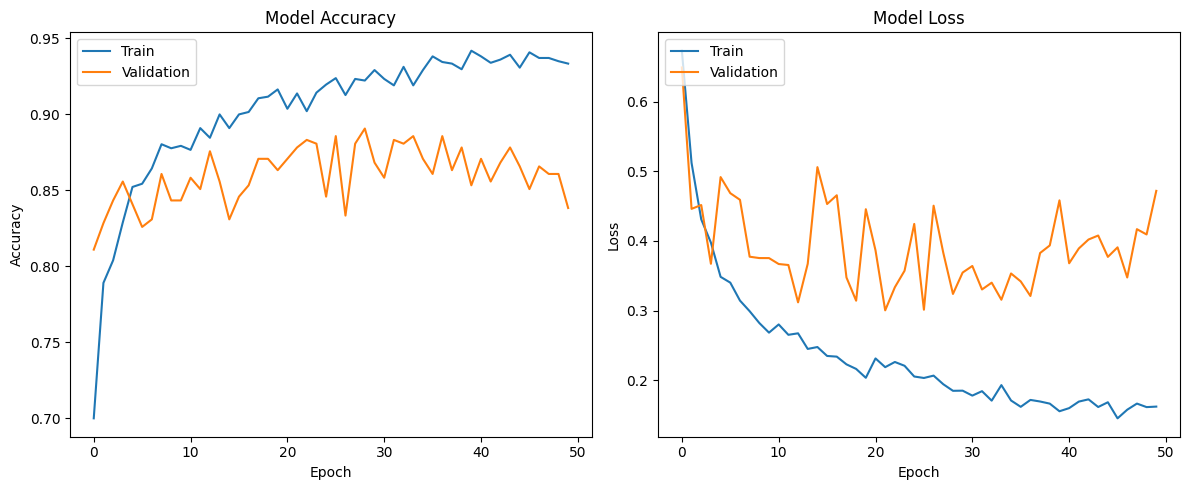

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy and loss side by side
plt.figure(figsize=(12, 5))  # Adjust the figure size as needed

# Accuracy subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Ensure the subplots do not overlap
plt.show()

In [14]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

num_test_sample=len(test_set)
num_classes=len(test_set.class_indices)

predicted_probabilities=model.predict(test_set,steps=num_test_sample)
predicted_labels=np.argmax(predicted_probabilities,axis=1)

true_labels=test_set.classes

report=classification_report(true_labels,predicted_labels)
print(report)

1/7 ━━━━━━━━━━━━━━━━━━━━ 1:15 13s/step

W0000 00:00:1711985923.644476      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/7 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step  

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


3/7 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 94s 14s/step
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       159
           1       0.84      0.99      0.91       251

    accuracy                           0.88       410
   macro avg       0.91      0.85      0.86       410
weighted avg       0.89      0.88      0.87       410



2/7 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


3/7 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 92s 14s/step


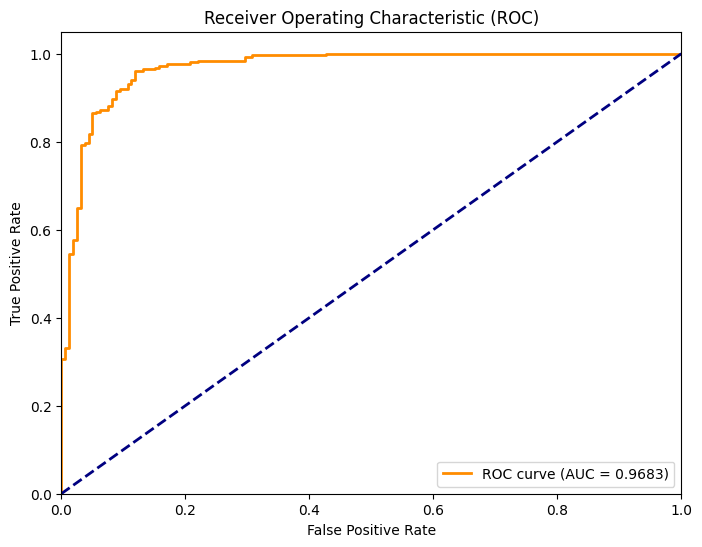

In [15]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred = model.predict(test_set)

# Assuming you have true labels for the test set
y_true = test_set.classes

# Step 2: Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

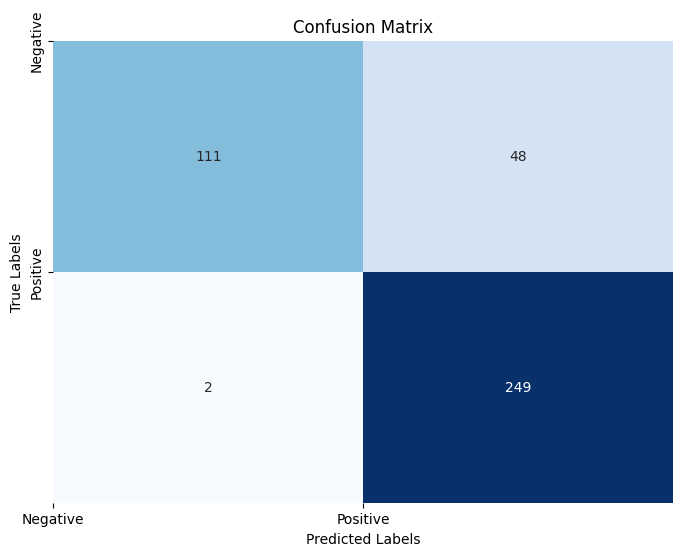

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels (y_true) and predicted labels (predicted_labels)
# Compute the confusion matrix
cm = confusion_matrix(y_true, predicted_labels)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

In [17]:
# Sensitivity and Specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"\nSensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

# Precision, Recall, G-measure, F1 Score
precision = tp / (tp + fp)
recall = sensitivity  # same as sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)
g_measure = 2 * ((precision * recall) / (precision + recall))

print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"G-measure: {g_measure}")



Sensitivity: 0.9920318725099602
Specificity: 0.6981132075471698

Precision: 0.8383838383838383
Recall: 0.9920318725099602
F1 Score: 0.9087591240875912
G-measure: 0.9087591240875912
